# End-to-End Camera Calibration

Simulated data to support the idea of end-to-end camera transformation.

For details on the idea, see [the doc](https://docs.google.com/document/d/1-ikSOxtrC4HLzd8xBdokjfMbbz0616eOBsco-bDk3os/edit)

### Imports

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import cv2
np.set_printoptions(precision=2, floatmode='fixed', suppress=True, threshold=10)

### Real world points

In [202]:
# +/- 1 meter side to side, 1-3 meters up
# TODO: wpi coords
x_space = np.linspace(-5, 5, 50)
y_space = np.linspace(1, 3, 5)
z_space = np.linspace(-5, 15, 50)
X, Y, Z = np.meshgrid(x_space, y_space, z_space)
X = X.reshape(1, -1).T
Y = Y.reshape(1, -1).T
Z = Z.reshape(1, -1).T

### Camera intrinsics and pose

In [200]:
# calibration matrix
K = np.array([[500.0, 0.0, 250.0], [0.0, 500.0, 250.0], [0.0, 0.0, 1.0]])

# distortion coefficients (k1, k2, p1, p2, k3)
# A LOT of distortion, in order to see it work.
distCoeffs = np.array([1.5, -0.95, -0.005, 0.0025, 1.16])
# distCoeffs = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

# camera rotation. in camera coords, pitch up is along x; 0.5 rad is a reasonable pitch
rvec = np.array([0.5, 0.0, 0.0])
# no camera translation
tvec = np.array([0.0, 0.0, 0.0])

### Project points to pixels, (u, v)

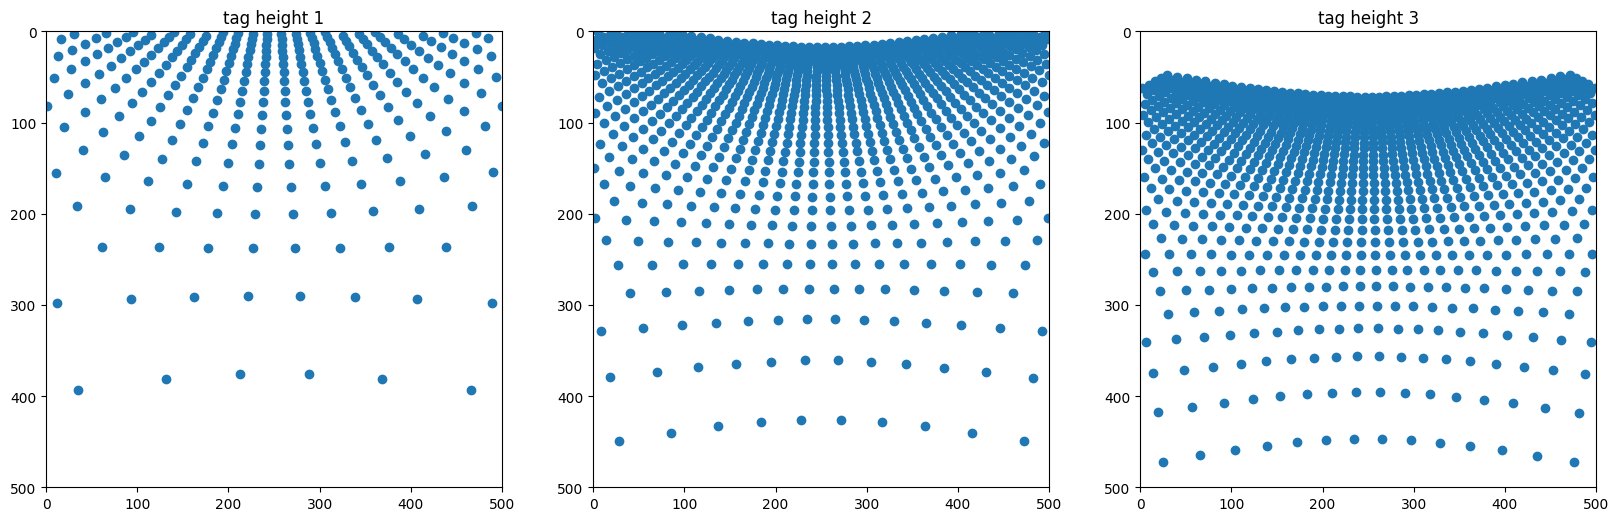

In [203]:
XYZ = np.hstack((X, Y, Z))
U_dist, _ = cv2.projectPoints(XYZ, rvec, tvec, K, distCoeffs)
uv = U_dist[:, 0]

uvY = np.hstack((uv, Y))
uvY = uvY[(uv[:, 0] >= 0) & (uv[:, 1] >= 0) & (uv[:, 0] <= 500) & (uv[:, 1] <= 500)]

fig, ax = plt.subplots(1,3, figsize=(20,7))

for i in range(3):
    tag_height = i + 1
    uvY_viz = uvY[uvY[:, 2] == tag_height]

    ax[i].scatter(uvY_viz.T[0], uvY_viz.T[1])
    ax[i].set_title(f"tag height {tag_height}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis() # camera y is positive-down
# add some realistic noise -- a few pixels worth 
# uv_noisy = uv + np.random.normal(0, 5, uv.shape)

# plt.scatter(uv.T[0], uv.T[1])
# plt.scatter(uv_noisy.T[0], uv_noisy.T[1])

# plt.gca().set_aspect("equal")
# plt.xlim(0, 500)
# plt.ylim(0, 500)
plt.show()

### Predict XZ (robot-relative Translation2d)  from simulated uvY

In [220]:
# uvY_noisy = np.hstack((uv_noisy, Y))
# uvY_noisy = uvY_noisy[(uv_noisy[:, 0] >= 0) & (uv_noisy[:, 1] >= 0) & (uv_noisy[:, 0] <= 500) & (uv_noisy[:, 1] <= 500)]

XZ = np.hstack((X, Z))
XZ = XZ[(uv[:, 0] >= 0) & (uv[:, 1] >= 0) & (uv[:, 0] <= 500) & (uv[:, 1] <= 500)]

# XZ is XY in wpi coords.  uvY is uvZ in wpi coords
# note: with a lot of points, RBFInterpolator goes REALLY slowly, and the "neighbors" thing only helps a little
# neighbors = 10 => 200 us
#uvy_to_xz = interp.RBFInterpolator(uvY, XZ, neighbors=10)
# the linear interpolator works fine with lots of points.
# 10 us (20x faster!)
uvy_to_xz = interp.LinearNDInterpolator(uvY, XZ)
predictedXZ = uvy_to_xz(uvY)
print(predictedXZ)

[[-2.14  6.43]
 [-2.14  6.84]
 [-1.94  5.61]
 ...
 [ 5.00 14.18]
 [ 5.00 14.59]
 [ 5.00 15.00]]


### What do these functions look like?

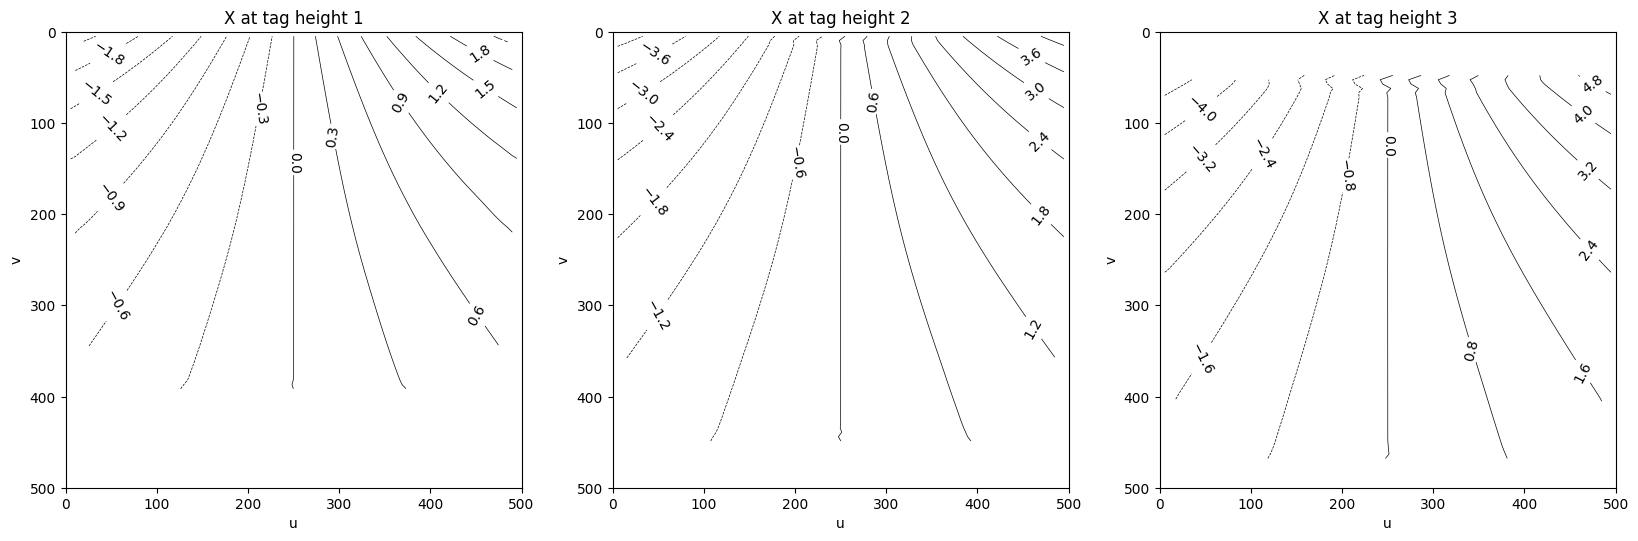

In [217]:
fig, ax = plt.subplots(1,3, figsize=(20,7))

# select just one value of Y (because we know it from the tag id)
for i in range(3):
    tag_height = i + 1
    uvY_viz = uvY[uvY[:, 2] == tag_height]
    predictedXZ_viz = predictedXZ[uvY[:, 2] == tag_height]
    xi = np.linspace(uvY[:, 0].min(), uvY[:, 0].max(), 100)
    yi = np.linspace(uvY[:, 1].min(), uvY[:, 1].max(), 100)
    zi = interp.griddata(
        (uvY_viz[:, 0], uvY_viz[:, 1]),
        predictedXZ_viz[:, 0],
        (xi[None, :], yi[:, None]),
        method="cubic",
    )

    # xig, yig = np.meshgrid(xi, yi)

    CS = ax[i].contour(xi, yi, zi, 15, linewidths=0.5, colors="black")
    plt.clabel(CS, inline=1, fontsize=10)
    ax[i].set_xlabel("u")
    ax[i].set_ylabel("v")
    ax[i].set_title(f"X at tag height {tag_height}")
    ax[i].set_aspect("equal")
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(0, 500)
    ax[i].invert_yaxis()
plt.show()

### Fill the frame

### RBFInterpolator performance

This shows about 10 us on my laptop, which is a 3 GHz i7; a Raspberry Pi 4 runs at 1.8 GHz, so say it's half as fast, so the interpolation might take 20 us.

Compare this to the previous design which took 13 **milliseconds** to undistort the whole frame, and then the RoboRIO (much slower) would do the pose transformation.

In [221]:
import time

t1 = time.time()
n = 100000
for i in range(n):
    uvy_to_xz([[157.08, 155.57, 1.00]])
t2 = time.time()
print(f"duration (sec) {(t2 - t1):.2f}")
print(f"duration per prediction (microsec) {(1e6*(t2-t1)/n):.2f}")

duration (sec) 1.06
duration per prediction (microsec) 10.59


### References

see more on [projectpoints](https://forum.opencv.org/t/understanding-the-functions-projectpoints-and-undistortpoints/10847)

and an example of [interpolation](https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy)